<a href="https://colab.research.google.com/github/sb8919/Travelplus/blob/main/Travelplus/DL_model/BERT_%ED%83%9C%EA%B7%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 패키지 다운로드
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.3 MB/s eta 0:00:00


In [7]:
# 주요 패키지 불러오기
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import folium
import numpy as np
import random
import time
import datetime

In [8]:
# GPU 확인
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


-------------

In [12]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
# 라벨링 파일 데이터 프레임 형태로 가져오기
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/labeling_data_0521.xlsx')

In [16]:
# 인스타그램 본문 내용에서 특수문자 공백으로 교환
df["sentences"] = df["sentences"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [17]:
# 인스타그램 태그 내용에서 특수문자 공백으로 교환
df["tags"] = df["tags"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

In [18]:
# 10개의 데이터 랜덤으로 출력
df.sample(n=10)

,Unnamed: 0,sentences,tags,place,label
8247,8247,아이와제주 야외에서 놀기 좋은 곳,렛츠런파크 제주민속촌 제주해양동물박물관 지난 렛츠런파크제주 애월 ...,환상의 섬 Jeju Island,4.0
5677,5677,행주산성 이영자 철판 삼겹살 맛집 철판에 흑돼지 김치 볶볶정말 말모말모 먹는 ...,아이맛이야장작철판구이 고양가볼만한곳 고양맛집 덕양맛집 덕양 행주...,아이맛이야장작철판구이,8.0
5589,5589,수원에서 처음 본 풍경 특정계절 각 도시마다 계절별로 꼭 나오는 사진들이 있습니...,TheDramatic_Suwon 수원여행 수원핫플 수...,동북각루(東北角樓) / 방화수류정(訪花隨柳亭),3.0
4966,4966,스지와 아롱사태가 한판에 완전 쫄깃쫀득함 비염으로 고생한다 그러면 냉채수육으로...,사상구석부산 사상맛집 사상술집 사상안주맛집 사상가볼만한곳 부산스...,NaN,8.0
1119,1119,언니가 가져다준,조선옥수수 미니옥수수 찰옥수수를 핑크뮬리도 함평군에서 함평핑크뮬...,NaN,1.0
4743,4743,_날 좋은 날 할배랑 할매랑 토끼 풀 주러 또 감,창녕산토끼동산 창녕가볼만한곳 창녕이방 아기랑갈만한곳 키즈모델김채니 ...,NaN,1.0
5836,5836,리그램 100y_gyeongju_ 황리단길 찐 로컬맛집 백년손님 황리단...,경주맛집 황리단길맛집 경주가볼만한곳 경주황리단길맛집 경주카페 경...,NaN,1.0
6757,6757,전혁림미술관 개관20주년 듣기만 해도 웅장하다 2003년 개관을 기념하는 세미나...,전혁림미술관 전혁림 전혁림미술관개관20주년 듣기만해도웅장해져요 통영...,전혁림미술관,7.0
4305,4305,리그램 sticky_bp 놀러오세요𝑺 𝒕 𝒊 𝒄 𝒌 𝒚 평리단길 스티커사...,평리단길카페 평리단길맛집 평리단길네일 평리단길미용실 부평역술집 ...,NaN,3.0
2150,2150,숲으로 둘러 싸인 절경 가득한 펜션펜션 이용 하신 후 참숯불가마찜찔방 무료로 이용하...,숲을그리다 여주맛집 블루헤런맛집 양평TPC맛집 스카이밸리맛집 여...,NaN,8.0


In [19]:
# label 열의 값 float-> str
df['label'] = df['label'].astype(str)

In [20]:
# label 분류 숫자로 변경
df.loc[(df['label'] == "0.0"), 'label'] = 0  #0.0 => 스팸 => 0
df.loc[(df['label'] == "1.0"), 'label'] = 1  #1.0 => 가볼만한곳 => 1
df.loc[(df['label'] == "2.0"), 'label'] = 2  #2.0 => 가족여행 => 2
df.loc[(df['label'] == "3.0"), 'label'] = 3  #3.0 => 관람 => 3
df.loc[(df['label'] == "4.0"), 'label'] = 4  #4.0 => 맛집 => 4
df.loc[(df['label'] == "5.0"), 'label'] = 5  #5.0 => 우정여행 => 5
df.loc[(df['label'] == "6.0"), 'label'] = 6  #6.0 => 전통 => 6
df.loc[(df['label'] == "7.0"), 'label'] = 7  #7.0 => 체험 => 7
df.loc[(df['label'] == "8.0"), 'label'] = 8  #8.0 => 카페 => 8
df.loc[(df['label'] == "9.0"), 'label'] = 9  #9.0 => 캠핑 => 9

<Axes: >

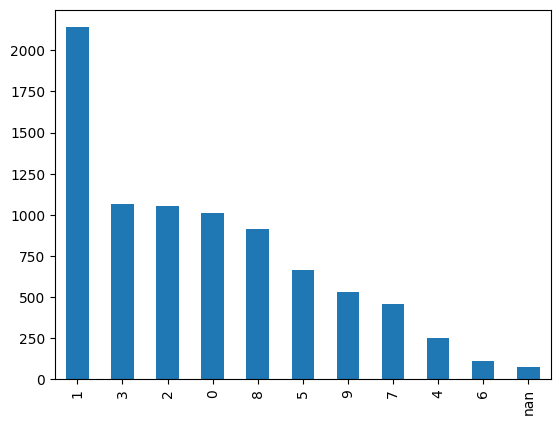

In [23]:
# 데이터 정제하기
# label 값 분포 확인
df['label'].value_counts().plot(kind = 'bar')

In [24]:
# 각 label 별 갯수 확인
df['label'].value_counts()

1      2141
3      1067
2      1053
0      1011
8       915
5       664
9       531
7       457
4       253
6       110
nan      73
Name: label, dtype: int64

In [25]:
# Null 값 유무 확인 True <- Null 값 있음
print(df.isnull().values.any())

True


In [26]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0       0
sentences        1
tags             0
place         5246
label            0
dtype: int64


In [27]:
# Null 값 많은 place 열 제거
df = df.drop('place',axis=1)

In [29]:
# 데이터 확인
df

,Unnamed: 0,sentences,tags,label
0,0,술이 달다 라고 하는걸 이걸보구 말하나봐요알쓰들도 무한대로 마실수 있는 연말을 ...,선릉 평상술집 술 술집 술안주 꿀주 꿀막걸리 막걸리 ...,8
1,1,,강남카페 강남대형카페도심 카즐_서울 카즐_강남 카즐_가로수길 카...,1
2,2,,강남카페 강남대형카페도심 카즐_서울 카즐_강남 카즐_가로수길 카...,2
3,3,연타발 압구정 완전 대박인듯ㅜㅜ어느 하나 모자람없는 이 맛을 다양한 세계로 이끌어가...,도산공원맛집 연타발압구정본점 강남맛집 신사동맛집 압구정맛집 도산...,1
4,4,연타발 압구정 완전 대박인듯ㅜㅜ어느 하나 모자람없는 이 맛을 다양한 세계로 이끌어가...,도산공원맛집 연타발압구정본점 강남맛집 신사동맛집 압구정맛집 도산...,8
...,...,...,...,...
8270,8270,올드카에 관심 있다면 규슈 자동차 박물관2023 03 08,사진 여행사진 일본 여행 유후인 일본여행 후쿠오카 규슈 ...,7
8271,8271,조선의 외교관 역관 부산박물관 특별기획전 전시관람하고 왔어요 아직 어린 아들...,부산박물관 특별기획전 전시관람 전시연출 박물관 포토스팟 역관...,7
8272,8272,어벤져스 엔드게임의 감동을 다시 한 번 피규어뮤지엄제주 2023 03 15,사진 여행사진 한국 제주 여행 풍경 한국여행 제주도 ...,7
8273,8273,사 한국박물관협회 회장 조한희 는 지난 5월 11일 목 부터 13일 토 까지 3일...,한국박물관협회 한박협 뮤지엄 박물관 미술관 제17회한국박물관국제...,0


In [30]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0    0
sentences     1
tags          0
label         0
dtype: int64


In [31]:
# Null값 제거
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [32]:
# Null값 제거 후 데이터 개수 확인
print(len(df))

8274


1      2141
3      1067
2      1053
0      1011
8       915
5       663
9       531
7       457
4       253
6       110
nan      73
Name: label, dtype: int64


8274

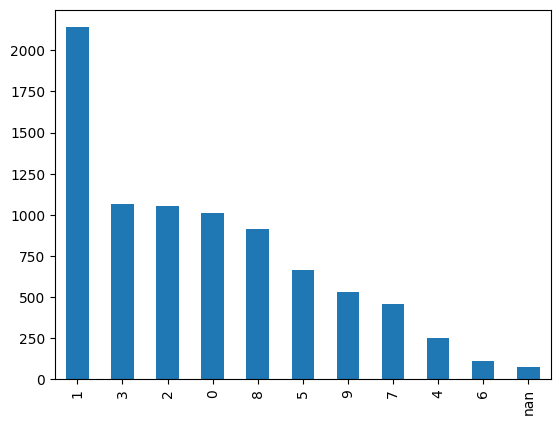

In [33]:
# Null값 제거 후 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [34]:
# label에서 nan 제거
df = df[df.label != 'nan']

1    2141
3    1067
2    1053
0    1011
8     915
5     663
9     531
7     457
4     253
6     110
Name: label, dtype: int64


8201

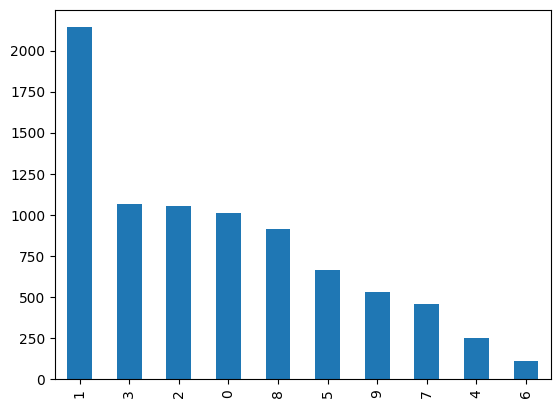

In [35]:
# 각 label별 갯수 확인
df['label'].value_counts().plot(kind = 'bar')
print(df['label'].value_counts())
len(df)

In [36]:
# data_list에 본문과 라벨링된 값 저장
data_list = []
for q, label in zip(df['tags'], df['label'])  :
    if q.strip() == '' or q.strip() == '.':
        print(q)
        continue
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [37]:
print(data_list[0])
print(data_list[500])
#print(data_list[1200])
# print(data_list[1800])
# print(data_list[2400])
# print(data_list[2800])
# print(data_list[-1])

[' 선릉   평상술집   술   술집   술안주   꿀주   꿀막걸리   막걸리   선릉맛집   선릉술집   강남술집', '8']
[' 아야진   아야진펜션   아야진해수욕장   속초여행   고성여행   속초펜션   속초숙소   속초펜션추천   속초가볼만한곳   고성가볼만한곳   감성숙소   감성스테이   고성숙소   노천탕펜션   아야진해변   신축펜션   설악산   고성스테이   속초스테이   오션뷰펜션   고성오션뷰펜션   강원도고성펜션   강원도속초펜션   양양가볼만한곳   강원도풀빌라   속초풀빌라   노천탕   속초커플펜션   오션뷰카페   속초펜션추천   고성펜션추천', '2']


In [38]:
#train & test 데이터로 나누기 train 80 test 20
from sklearn.model_selection import train_test_split
                                                         
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [39]:
# train data, test data 개수 확인
print(len(train))
print(len(test))

6560
1641


In [40]:
print(train)

      Unnamed: 0                                          sentences  \
8029        8029  𝓡𝓞𝓜𝓐 난 항상 이탈리아  특히 로마의 명성이 과장되었다고 생각했다  하지만 완전...   
4031        4031  안녕하세요  남영동양문 신촌점입니다  저희는 소갈비포를 직접 뜨고 있습니다  어서 ...   
6480        6480  잠시 짬을 내어 랑군님과 데이또연두 초록이 덕분에 눈이 맑아지는듯자연을 담아 마시는...   
6551        6551  광양에 있는 웨이팅쩔 숯불 닭구이집  맛집으로 소문 낭낭해서 알사람들은 다 아는곳 ...   
5665        5665  여행장소추천 _실시간 고양 꽃 박람회 풍경  2023  5 1  오늘은 근로자의 날...   
...          ...                                                ...   
4426        4426  삼척주변 여행지 날씨까지 완벽했던 여행마지막날 삼척에서 20분 거리라 다녀왔는데진심...   
7965        7965  한 번 먹으면 중독되서 못 벗어나요 오늘 저녁엔 소주 한잔   최고의 안주가 준비되...   
4912        4912  성산면에 있다는 푸릇푸릇 논뷰 포레스트 감성 바베큐집   도심을 벗어나 힐링듬뿍 탁...   
3302        3302  오늘 가평 음악역 콘서트는 신현희 가수가 와서 신나게 놀다 갔다 코로나 시국에서 조...   
2751        2751  나만의 밀양6경  그 마지막 장소 걸음 속에 쉼이 있는 곳  밀양 칠곡 여행기도 이...   

                                                   tags label  
8029   쥴리미엘의여행기  _프이   유럽여행   이탈리아여행   로마여행   로마   유...     1  
4031   남영동양문신촌점   서

------

문장별 전처리

In [41]:
# CLS, SEP 붙이기 (문장의 시작, 끝)
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.tags]

In [42]:
document_bert[:5]

['[CLS]  쥴리미엘의여행기  _프이   유럽여행   이탈리아여행   로마여행   로마   유적   유물   travel   italia   roma      [SEP]',
 '[CLS]  남영동양문신촌점   서대문구맛집   서대문맛집   창천동맛집   신촌맛집   신촌역맛집   남영동양문   맛집   먹스타맞팔환영   신촌역술집추천   프로먹방러   서대문구소갈비맛집   서대문가볼만한곳   창천동모임   서대문핫플   신촌고기집   신촌핫플 [SEP]',
 '[CLS]  안양예술공원   안양가볼만한곳   경기도가볼만한곳 [SEP]',
 '[CLS]  차도리가든    광양맛집   광양맛집추천   광양가볼만한곳   광양데이트   광양핫플   광양맛집투어 [SEP]',
 '[CLS]  2023고양국제꽃박람회   태안국제튤립꽃박람회   고양꽃박람회   고양국제꽃박람회   2023년고양꽃박람회   고양꽃박람회주차   고양꽃박람회입장요금   사진찍기좋은곳   고양가볼만한곳   서울근교가볼만한곳   핫여행지   여행지추천   여행장소추천   봄꽃구경   데이트하기좋은곳   가족여행하기좋은곳   일산호수공원 [SEP]']

In [43]:
#사전 학습된 BERT multilingual 모델 내 포함되어있는 토크나이저 활용
print('tokenizeing..')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)
tokenized_texts = [ tokenizer.tokenize(s) for s in document_bert]
print('tokenized_texts[0]:',tokenized_texts[0])

tokenizeing..


tokenized_texts[0]: ['[CLS]', '[UNK]', '_', '프', '##이', '유럽', '##여', '##행', '이탈리아', '##여', '##행', '로마', '##여', '##행', '로마', '유', '##적', '유', '##물', 'travel', 'it', '##alia', 'rom', '##a', '[SEP]']


In [44]:
#token들의 max length보다 크게 MAX_LEN을 설정한다. 설정한 MAX_LEN만큼 빈 공간을 0 이 채운다
print('padding')
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]
print('input_ids[0]:',input_ids[0])

padding
input_ids[0]: [  101   100   168  9942 10739 68495 29935 25549 73668 29935 25549 74805
 29935 25549 74805  9625 14801  9625 29364 23595 10271 35954 86945 10113
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [45]:
#학습 속도를 높이기 위해 실 데이터가 있는 곳과 padding이 있는곳을 attention에게 알려줌

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print('attention_masks[0]:',attention_masks[0])

attention_masks[0]: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [46]:
# input 과 mask가 뒤섞이지 않도록 random_state를 일정하게 고정.
# test set은 위에서 분리되었기에 , train 과 validation set만 분리
print('split train - val')
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, train['label'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42,test_size=0.1)

split train - val


In [47]:
train_labels = train_labels.astype(int)

In [48]:
validation_labels = validation_labels.astype(int)

In [49]:
# numpy ndarray로 되어있는 input,lable,mask들을 torch tensor로 변환
print('convert data to tenser..')
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

convert data to tenser..


In [56]:
#현재 쓰고있는 GPU의 VRAM에 맞게 배치사이즈 설정(크게 설정후 부족메시지가 뜨면 8의 배수중 작은것으로 줄여나가기)
print('set batch and data loader')
BATCH_SIZE = 80

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

set batch and data loader


In [57]:
#위의 train-val 셋 전처리와 동일
print('data split')
sentences = test['tags']
sentences = ["[CLS]"+str(sentence)+"[SEP]" for sentence in sentences]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

labels = labels.astype(int)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

data split


In [58]:
import torch

print(torch.cuda.is_available())  # CUDA를 사용할 수 있는지 확인
print(torch.cuda.device_count())  # 사용 가능한 CUDA 디바이스 개수 확인

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))  # CUDA 디바이스 이름 출력


True
1
Tesla T4


In [59]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')


## 분류를 위한 BERT 모델 생성
# transformers 의 BertForSequenceClassification 모듈 이용
print('making BERT model for classification')
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=10)
#model.cuda()
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
making BERT model for classification


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [61]:
# transformers에서 제공하는 옵티마이저 중 AdamW를 사용
# 총 훈련 스텝은 이터레이션 * 에폭 수로 설정
# 러닝 레잇 스케쥴러도 transformers에서 제공하는것을 사용

#옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 50

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

##학습
# accuracy 와 시간 표시함수 정의
# 정확도 계산 함수
print('train start')
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

train start


In [62]:
# 데이터로더에서 배치만큼 가져온 후 forward, backward pass를 수행
# gradient update는 명시적으로 하지 않고 위에서 로드한 optimizer를 활용
# 재현을 위해 랜덤시드 고정
# 모든 Epoch를 학습하면 학습이 종료

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("")


======== Epoch 1 / 50 ========
Training...

  Average training loss: 2.00
  Training epcoh took: 0:01:48

Running Validation...
  Accuracy: 0.33
  Validation took: 0:00:04

======== Epoch 2 / 50 ========
Training...

  Average training loss: 1.76
  Training epcoh took: 0:01:48

Running Validation...
  Accuracy: 0.35
  Validation took: 0:00:04

======== Epoch 3 / 50 ========
Training...

  Average training loss: 1.62
  Training epcoh took: 0:01:48

Running Validation...
  Accuracy: 0.33
  Validation took: 0:00:04

======== Epoch 4 / 50 ========
Training...

  Average training loss: 1.51
  Training epcoh took: 0:01:47

Running Validation...
  Accuracy: 0.34
  Validation took: 0:00:04

======== Epoch 5 / 50 ========
Training...

  Average training loss: 1.42
  Training epcoh took: 0:01:47

Running Validation...
  Accuracy: 0.33
  Validation took: 0:00:04

======== Epoch 6 / 50 ========
Training...

  Average training loss: 1.35
  Training epcoh took: 0:01:48

Running Validation...
  Accu

In [63]:
print('test start')
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))
print("test finished!")

test start

Accuracy: 0.18
Test took: 0:00:10
test finished!
